In [1]:
# Load the tfa model 
from pytfa.io.json import load_json_model
model_file = 'reduced_model_ETC_core_20250228-213124_continuous.json'
tmodel = load_json_model(model_file)
#sol = tmodel.optimize()

2025-09-16 11:54:49,266 - thermomodel_Recon3thermoCurated - continuous - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


In [ ]:
# Reload and prepare the model
from skimpy.io.yaml import load_yaml_model
from skimpy.utils.tabdict import TabDict

kmodel = load_yaml_model(model_file.replace("_continuous.json", "_kinetic_curated_h_const.yml"))

# Compile the ode expressions
NCPU = 12
kmodel.prepare()
kmodel.compile_ode(ncpu=NCPU)

In [17]:
kmodel.moieties

[{'coa_m': 1.0,
  'aacoa_m': 1.0,
  'accoa_m': 1.0,
  'succoa_m': 1.0,
  'pmtcoa_m': 1.0},
 {'icit_m': 1.0,
  'cit_m': 1.0,
  'succoa_m': 1.0,
  'akg_m': 1.0,
  'mal_L_m': 1.0,
  'oaa_m': 1.0,
  'fum_m': 1.0,
  'succ_m': 1.0},
 {'adp_c': 1.0, 'atp_c': 1.0, 'amp_c': 1.0},
 {'nadh_m': 1.0, 'nad_m': 1.0},
 {'akg_c': 1.0, 'mal_L_c': 1.0, 'oaa_c': 1.0},
 {'glu_L_m': 1.0, 'asp_L_m': 1.0},
 {'asp_L_c': 1.0, 'glu_L_c': 1.0},
 {'atp_m': 1.0, 'adp_m': 1.0},
 {'pmtcrn_c': 1.0, 'crn_c': 1.0},
 {'coa_c': 1.0, 'pmtcoa_c': 1.0},
 {'crn_m': 1.0, 'pmtcrn_m': 1.0},
 {'ficytC_m': 1.0, 'focytC_m': 1.0},
 {'q10_m': 1.0, 'q10h2_m': 1.0},
 {'fad_m': 1.0, 'fadh2_m': 1.0},
 {'nadh_c': 1.0, 'nad_c': 1.0},
 {'gtp_m': 1.0, 'gdp_m': 1.0}]

In [ ]:
1/0

In [3]:
# Scaling parameters
CONCENTRATION_SCALING = 1e3 # 1 mol to 1 mmol
TIME_SCALING = 1 # 1min
DENSITY = 1200 # g/L 
GDW_GWW_RATIO = 1.0 # Fluxes are in gWW

# To test how close to zero the dxdt is
flux_scaling_factor = 1e-6 / (GDW_GWW_RATIO / DENSITY) \
                        * CONCENTRATION_SCALING \
                        / TIME_SCALING

In [4]:
# Load TFA samples 
import pandas as pd
import numpy as np
tfa_sample_file = 'reduced_model_ETC_core_20250228-213124_tfa_sampling.csv'
tfa_samples = pd.read_csv(tfa_sample_file)


faraday_const = 23.061 # kcal / mol / V
RT = tmodel.RT # kcal /mol
delta_psi_scaled = 150/1000 * faraday_const / RT  # mV * F / RT 

# Psuedo data for the membrane potential
tfa_samples['psi_m_c'] = delta_psi_scaled * 1e-3 # be aware of the scaling!!!
tfa_samples['MitoMembranePot_in'] = 1000 # ~ 1000 RT/min -> at 5 RT is equivalent to about 2 min time scale for the membrane potential
tfa_samples['MitoMembranePot_out'] = 1000

# 30 min timescale for insulin action 
tfa_samples['Insulin_secretion'] = 1/30 / flux_scaling_factor
tfa_samples['Insulin_degradation'] = 1/30 / flux_scaling_factor
tfa_samples['insulin_e'] = 1e-3 

additional_fluxes = ['MitoMembranePot_in','MitoMembranePot_out', 'Insulin_secretion', 'Insulin_degradation',]
additional_concentrations = ['psi_m_c', 'insulin_e']

In [5]:
CONCENTRATION_SCALING

1000.0

In [6]:
# Load only the robust parameters samples
from skimpy.core.parameters import load_parameter_population
parameter_population = load_parameter_population(tfa_sample_file.replace(".csv",'_robust_parameters.hdf5'))


In [7]:
# Build function to compute fluxes from concentrations
from skimpy.analysis.ode.utils import make_flux_fun
from skimpy.utils.namespace import QSSA

flux_function = make_flux_fun(kmodel, QSSA)

Process SpawnPoolWorker-2:
Process SpawnPoolWorker-4:
Process SpawnPoolWorker-10:
Process SpawnPoolWorker-12:
Process SpawnPoolWorker-5:
Process SpawnPoolWorker-7:
Process SpawnPoolWorker-6:
Process SpawnPoolWorker-9:
Process SpawnPoolWorker-1:
Process SpawnPoolWorker-8:
Process SpawnPoolWorker-11:
Process SpawnPoolWorker-3:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniconda/base/envs/skimpy-env/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniconda/base/envs/skimpy-env/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/homebrew/Caskroom/miniconda/base/envs/skimpy-env/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/opt/homebrew/Caskroom/miniconda/base/envs/skimpy-env/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/

KeyboardInterrupt: 

In [ ]:
from skimpy.core.parameters import ParameterValues
from skimpy.analysis.oracle import load_concentrations, load_fluxes

from tqdm import tqdm

# Function for population analysis
def dynamic_perturbation(parameter, fold_change,
                            additional_parameter_changes={},
                            time = [0, 500], # make sure its at steady state
                            parameter_population=parameter_population, 
                            kmodel=kmodel, 
                            flux_function=flux_function,
                            tfa_samples=tfa_samples, 
                            end_ix=-1,
                            parameter_sets=None,
                            ):
    
    # List of dataframes
    results = []

    # Run the perturbation for each parameterset
    if parameter_sets is None:
        parameter_population_index = list(parameter_population._index.keys())[:end_ix]
    else:
        parameter_population_index = parameter_sets

    for parameter_set_id in tqdm(parameter_population_index):

        # This will be a list of dataframes
        this_results = []

        thermo_index = int(parameter_set_id.split(',')[0])
        thermo_sample = tfa_samples.loc[thermo_index]

        ref_concentrations = load_concentrations(thermo_sample, tmodel, kmodel, 
                                            concentration_scaling=CONCENTRATION_SCALING,
                                            additional_concentrations=additional_concentrations)

        ref_fluxes = load_fluxes(thermo_sample, tmodel, kmodel,
                                    density=DENSITY,
                                    ratio_gdw_gww=GDW_GWW_RATIO,
                                    concentration_scaling=CONCENTRATION_SCALING,
                                    time_scaling=TIME_SCALING,
                                    xmol_in_flux=1e-6,
                                    additional_fluxes=additional_fluxes)


        for k in kmodel.initial_conditions:
                kmodel.initial_conditions[k] = ref_concentrations[k]

        # Set h_m and h_c
        kmodel.parameters['h_c'].value = ref_concentrations['h_c']
        kmodel.parameters['h_m'].value = ref_concentrations['h_m']

        # Load the parameter values 
        kmodel.parameters = parameter_population[parameter_set_id]

        # Integrate additional parameters changes (fold changes)
        for k, v in additional_parameter_changes.items():
            kmodel.parameters[k].value = kmodel.parameters[k].value * v

        # Perturb the main parameter
        p0 = kmodel.parameters[parameter].value
        
        kmodel.parameters[parameter].value =  p0 * fold_change
        # Dynamic solution            
        sol = kmodel.solve_ode(time, solver_type='cvode' , max_steps=1e9, rtol=1e-6)
        # Get concentrations 
        concentrations = sol.concentrations

        # Compute the fluxes at steady state
        # Get parameters value set 
        parameter_values = {p.symbol:p.value for p in kmodel.parameters.values()}
        parameter_values = ParameterValues(parameter_values, kmodel)

        # Compute the fluxes at each time point
        fluxes = []
        for idx, conc_row in concentrations.iterrows():
            # Use the concentration row to compute fluxes
            time_fluxes = pd.Series(flux_function(conc_row[kmodel.reactants.keys()], parameters=parameter_values), 
                                    index=kmodel.reactions.keys())
            time_fluxes.name = idx  # Set the time as the series name
            fluxes.append(time_fluxes)

        # Concatenate the fluxes
        fluxes = pd.concat(fluxes, axis=1)

        # Normalize the fluxes
        fluxes = fluxes.T.div(ref_fluxes, axis=1)
        # Normalize the concentrations
        concentrations = concentrations.div(ref_concentrations, axis=1)

        # Add the results to a dataframe 
        output = pd.concat([concentrations, fluxes], axis=1)

        # Add metadata 
        output['time'] = time
        output['pertubration'] = fold_change
        output['parameter_set'] = parameter_set_id
        output['parameter'] = parameter    
        output['aditional_parameters'] = str([f'{k}:{v:.1f}' for k,v in additional_parameter_changes.items()])

        this_results.append(output)

        # Concatenate the results
        this_results = pd.concat(this_results, axis=1)

        results.append(this_results)
    
    # Concatenate the results
    results = pd.concat(results)

    return results


In [ ]:
# Extract the 10 best parameter sets from the fuel competition results
best_fuel_competition_results = pd.read_csv('./output/fuel_competition_rep_parameter_sets.csv')
best_parameter_sets = best_fuel_competition_results['parameter_set'].unique().tolist()

In [ ]:
# Run the dynamic perturbation for the main parameter
parameters = [ 'lac_L_e', 'hdca_e' , 'glc_D_e' , 'bhb_e',]

time = np.linspace(0, 60, 1000)  
#time = np.logspace(-3, 2, 500)  # Logarithmic space for better resolution at lower time
results = [dynamic_perturbation(p,5.0, parameter_population=parameter_population, time=time, 
                                parameter_sets=best_parameter_sets
                                ) for p in parameters]
results = pd.concat(results)


100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


In [ ]:
# Get olnly the best parameter fitting parameter sets (top 10)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare data for plotting
def prepare_plotting_data(results, selected_variables):
    """
    Prepare the data for plotting by melting the dataframe and adding metadata
    """
    # Use the existing time column from the results dataframe
    plot_data = results.reset_index()
    
    # Select only the columns we need for plotting plus metadata
    metadata_cols = ['time', 'pertubration', 'parameter_set', 'parameter', 'aditional_parameters']
    available_vars = [var for var in selected_variables if var in plot_data.columns]
    
    if not available_vars:
        print("Warning: None of the selected variables found in data")
        print("Available columns:", plot_data.columns.tolist()[:20])
        return None
    
    plot_data_subset = plot_data[metadata_cols + available_vars]
    
    # Melt the dataframe to long format
    melted_data = pd.melt(plot_data_subset, 
                         id_vars=metadata_cols,
                         value_vars=available_vars,
                         var_name='variable',
                         value_name='value')
    
    # Create a categorical variable to preserve order
    melted_data['variable'] = pd.Categorical(melted_data['variable'], 
                                           categories=available_vars, 
                                           ordered=True)
    
    # Create a combined identifier for parameter sets to distinguish lines
    melted_data['param_id'] = melted_data['parameter_set'] + '_' + melted_data['parameter']
    
    return melted_data

# Create the plotting function
def plot_dynamics_facetgrid(results, selected_variables, 
                           aspect=1.0, hspace=0.2, wspace=1.2,
                           ncols=3, colors=None, 
                           selected_parameters=None, annotation_dict=None):
    """
    Plot dynamics using seaborn FacetGrid with individual panels for each variable
    
    Parameters:
    -----------
    results : pd.DataFrame
        Results dataframe from dynamic_perturbation
    selected_variables : list
        List of variable names to plot (can be fluxes or concentrations)
    figsize : tuple
        Figure size (width, height)
    ncols : int
        Number of columns in the facet grid
    colors : dict or list, optional
        Colors for the parameters. If dict, should map parameter names to colors.
        If list, should have colors for each unique parameter.
        If None, uses a default color palette.
    selected_parameters : list, optional
        List of parameter names to plot. If None, plots all parameters.
        Example: ['lac_L_e', 'hdca_e'] to only plot lactate and fatty acid perturbations
    annotation_dict : dict, optional
        Dictionary mapping variable names to their annotations for y-axis labels
    """
    # Filter results by selected parameters if specified
    if selected_parameters is not None:
        results = results[results['parameter'].isin(selected_parameters)]
        if results.empty:
            print(f"Warning: No data found for parameters: {selected_parameters}")
            print(f"Available parameters: {results['parameter'].unique()}")
            return None, None
    
    # Prepare the data
    plot_data = prepare_plotting_data(results, selected_variables)
    
    if plot_data is None:
        return None, None
    
    # Set up colors
    unique_parameters = plot_data['parameter'].unique()
    if colors is None:
        # Use a nice default color palette
        colors = ["#000000", '#A23B72', '#F18F01', '#C73E1D', '#6A994E', '#815B5B'][:len(unique_parameters)]
    elif isinstance(colors, dict):
        colors = [colors.get(param, '#333333') for param in unique_parameters]
    elif isinstance(colors, list):
        colors = colors[:len(unique_parameters)]
    
    # Create color palette
    color_palette = dict(zip(unique_parameters, colors))
    
    # Calculate number of rows needed
    n_variables = len(plot_data['variable'].unique())
    nrows = (n_variables + ncols - 1) // ncols
    
    # Create FacetGrid
    g = sns.FacetGrid(plot_data, 
                      col='variable', 
                      col_wrap=ncols,
                      height=1.8, 
                      aspect=aspect,
                      sharey=False,  # Don't share y-axis since variables have different scales
                      sharex=True)   # Share x-axis (time)
    

    
    # Map the line plot
    g.map_dataframe(sns.lineplot, 
                   x='time', 
                   y='value', 
                   hue='parameter',  # Different parameters get different colors
                   units='param_id',  # Each parameter set is a separate line
                   estimator=None,  # Don't aggregate, plot all lines
                   alpha=1.0,
                   linewidth=1.0,
                   palette=color_palette
                   )
    
    # Customize the plot
    g.set_axis_labels("Time (min)", "")

    # Increase the marigin to avoid overlap
    g.fig.subplots_adjust(hspace=hspace, wspace=wspace)
    
    # Remove panel titles and customize y-axis labels
    for ax, var_name in zip(g.axes.flat, g.col_names):
        # Remove the panel title
        ax.set_title("")
        
        # Set custom y-axis label with annotation
        if annotation_dict and var_name in annotation_dict:
            ylabel = f"{annotation_dict[var_name]}\n(relative to basal)"
        else:
            ylabel = f"{var_name}\n(relative to basal)"
        ax.set_ylabel(ylabel)
        
        # Set y-axis limits from 0 to max*1.2
        var_data = plot_data[plot_data['variable'] == var_name]['value']
        if not var_data.empty:
            max_val = var_data.max()
            if pd.notna(max_val) and max_val > 0:
                ax.set_ylim(0, max_val * 1.1)
    
    # Rotate x-axis labels if needed
    for ax in g.axes.flat:
        ax.tick_params(axis='x', rotation=45)
        
    
    # Remove individual legends (they would be too crowded)
    for ax in g.axes.flat:
        if ax.get_legend():
            ax.get_legend().remove()
    
    # Add a single legend only if there are multiple parameters
    handles, labels = g.axes[0].get_legend_handles_labels()
    if handles and len(unique_parameters) > 1:
        g.figure.legend(handles, labels, 
                       title='Parameter',
                       bbox_to_anchor=(1.05, 0.5), 
                       loc='center left')
    
   #plt.tight_layout()
    
    return g, plot_data

In [ ]:
annotation_dict = {
    'hdca_c': 'Palmitate',
    'pmtcoa_c': 'FA-CoA',
    'FAOXC160': 'β-oxidation',
    'nad_m': 'NAD+',
    'nadh_m': 'NADH',
    'coa_m': 'CoA',
    'PDHm': 'PDH ',
    'LDH_Lm': 'LDHm ',
    'BDHm': 'BDH',
    'ACACT1rm': 'ACAT1',
    'pyr_m': 'Pyruvate',
    'lac_L_m': 'Lactate',
    'lac_L_c': 'Lactate',
    'bhb_m': 'β-hydroxybutyrate',
    'bhb_c': 'β-hydroxybutyrate',
    'glc_D_c': 'Glucose',
    'g3p_c': 'Glycerol-3-phosphate',
    'HEX1': 'HEX',
    'atp_c': 'ATP',
    'atp_m': 'ATP',
    'accoa_m': 'Acetyl-CoA',
    'NADH2_u10mi' : 'Complex I',
}

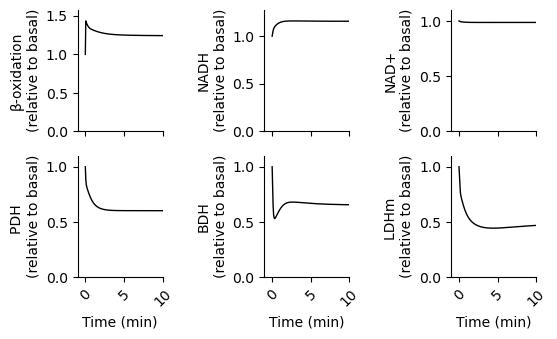

In [ ]:
# Select the variables to plot
selected_variables = ['FAOXC160', 'nadh_m', 'nad_m',
                      'PDHm' , 'BDHm' ,'LDH_Lm', 
                      ]


# Select which perturbations to plot
selected_perturbations = ['hdca_e',]  # Only plot lactate and fatty acid perturbations

g, plot_data = plot_dynamics_facetgrid(results, selected_variables, 
                                      ncols=3, 
                                      selected_parameters=selected_perturbations,
                                      annotation_dict=annotation_dict,
                                      colors=['black',]
                                      )

# Set ylimits for y-axis
for ax in g.axes.flat:
    ax.set_xlim(-1, 10)
    ax.set_xticks([0, 5, 10])
    ax.set_xticklabels([0,5, 10])


# Save the plot to a file
plt.savefig('./output/fuel_competition_dynamics_fatty_acid.svg', bbox_inches='tight',)

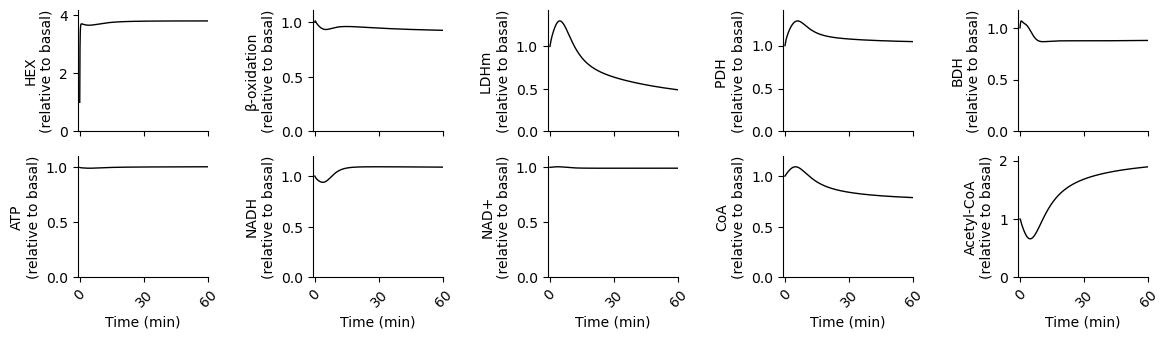

In [ ]:
# Select the variables to plot
selected_variables = ['HEX1', 'FAOXC160',  'LDH_Lm', 'PDHm',  'BDHm',
                      'atp_c','nadh_m' , 'nad_m',  'coa_m', 'accoa_m',
                      ]

# Select which perturbations to plot
selected_perturbations = ['glc_D_e',]  # Only plot lactate and fatty acid perturbations

g, plot_data = plot_dynamics_facetgrid(results, selected_variables, 
                                      aspect=1.3, wspace= 0.8, ncols=5, 
                                      selected_parameters=selected_perturbations,
                                      annotation_dict=annotation_dict
                                      )

# Set ylimits for y-axis
for ax in g.axes.flat:
    ax.set_xlim(-1, 60)
    ax.set_xticks([0, 30, 60])
    ax.set_xticklabels([0,30, 60])


# Save the plot to a file
plt.savefig('./output/fuel_competition_dynamics_glucose.svg', bbox_inches='tight',)

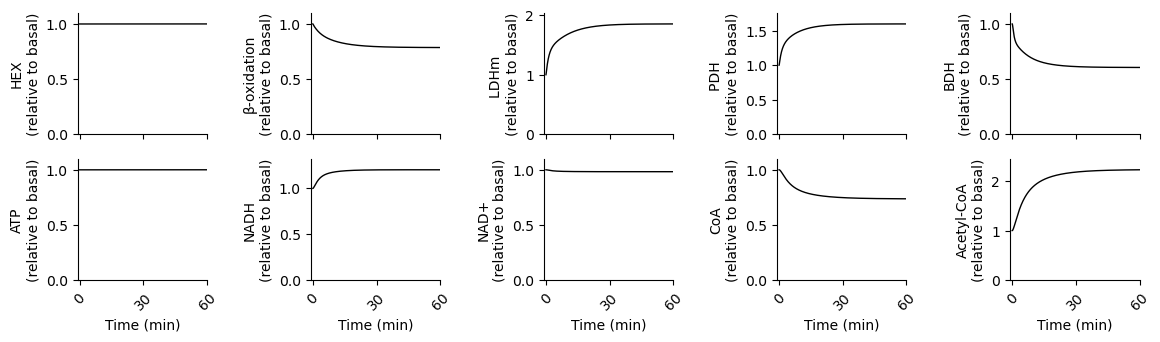

In [ ]:
# Select the variables to plot
# Select the variables to plot
selected_variables = ['HEX1', 'FAOXC160',  'LDH_Lm', 'PDHm',  'BDHm',
                      'atp_c','nadh_m' , 'nad_m',  'coa_m', 'accoa_m',
                      ]

# Select which perturbations to plot
selected_perturbations = ['lac_L_e',]  # Only plot lactate and fatty acid perturbations

g, plot_data = plot_dynamics_facetgrid(results, selected_variables, 
                                      aspect=1.3, wspace= 0.8, ncols=5, 
                                      selected_parameters=selected_perturbations,
                                      annotation_dict=annotation_dict
                                      )

# Set ylimits for y-axis
for ax in g.axes.flat:
    ax.set_xlim(-1, 60)
    ax.set_xticks([0, 30, 60])
    ax.set_xticklabels([0,30, 60])


# Save the plot to a file
plt.savefig('./output/fuel_competition_dynamics_lactate.svg', bbox_inches='tight',)

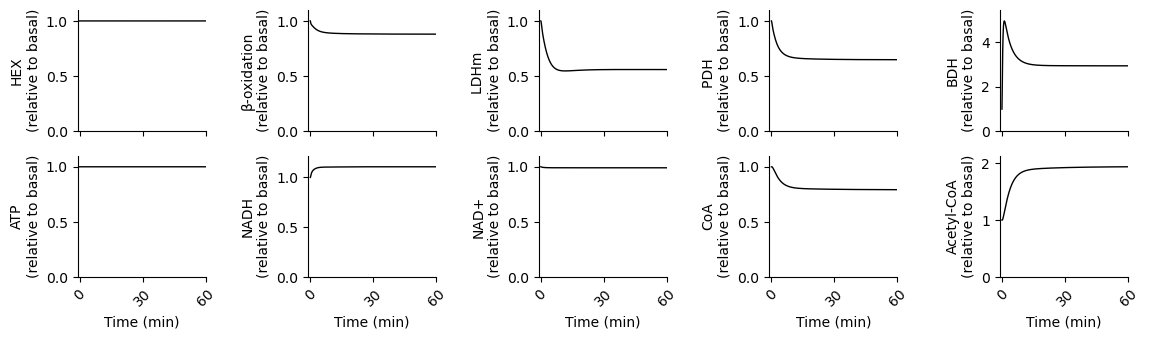

In [ ]:
# Select the variables to plot
selected_variables = ['HEX1', 'FAOXC160',  'LDH_Lm', 'PDHm',  'BDHm',
                      'atp_c','nadh_m' , 'nad_m',  'coa_m', 'accoa_m',
                      ]


# Select which perturbations to plot
selected_perturbations = ['bhb_e',]  # Only plot lactate and fatty acid perturbations

g, plot_data = plot_dynamics_facetgrid(results, selected_variables, 
                                      aspect=1.3, wspace= 0.8, ncols=5, 
                                      selected_parameters=selected_perturbations,
                                      annotation_dict=annotation_dict
                                      )

# Set ylimits for y-axis
for ax in g.axes.flat:
    ax.set_xlim(-1, 60)
    ax.set_xticks([0, 30, 60])
    ax.set_xticklabels([0,30, 60])


# Save the plot to a file
plt.savefig('./output/fuel_competition_dynamics_ketones.svg', bbox_inches='tight',)

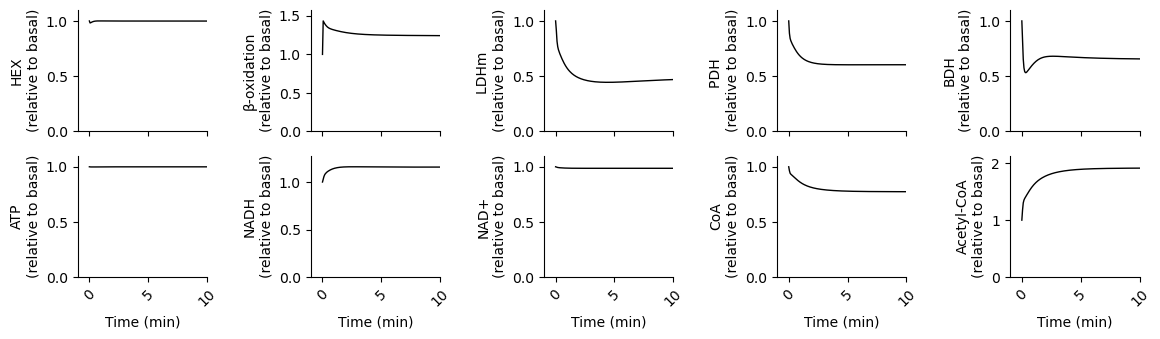

In [ ]:
# Select the variables to plot
selected_variables = ['HEX1', 'FAOXC160',  'LDH_Lm', 'PDHm',  'BDHm',
                      'atp_c','nadh_m' , 'nad_m',  'coa_m', 'accoa_m',
                      ]


# Select which perturbations to plot
selected_perturbations = ['hdca_e',]  # Only plot lactate and fatty acid perturbations

g, plot_data = plot_dynamics_facetgrid(results, selected_variables, 
                                     aspect=1.3, wspace= 0.8, ncols=5, 
                                      selected_parameters=selected_perturbations,
                                      annotation_dict=annotation_dict,
                                      colors=['black',]
                                      )

# Set ylimits for y-axis
for ax in g.axes.flat:
    ax.set_xlim(-1, 10)
    ax.set_xticks([0, 5, 10])
    ax.set_xticklabels([0,5, 10])


# Save the plot to a file
plt.savefig('./output/fuel_competition_dynamics_fatty_acid_2.svg', bbox_inches='tight',)